In [9]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from datetime import timedelta
import matplotlib.pyplot as plt

In [10]:
df = pd.read_csv('parkingLot.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Sort data by timestamp
df = df.sort_values('timestamp')
df = df[df['timestamp'].dt.hour.between(5, 23)]

# Separate data into entries (camera_id = 1) and exits (camera_id = 2)
df_entries = df[df['camera_id'] == 1]
df_exits = df[df['camera_id'] == 2]
daily_entry_counts = df_entries.groupby(df_entries['timestamp'].dt.date).size()
daily_entry_counts.index = pd.to_datetime(daily_entry_counts.index)
daily_entry_counts.name = 'daily_entries'

# Merge entries and exits based on vehicle_no to calculate time spent
df_merged = df_entries.merge(df_exits, on="vehicle_no", suffixes=('_entry', '_exit'))
df_merged['timestamp_exit'] = pd.to_datetime(df_merged['timestamp_exit'])
df_merged['timestamp_entry'] = pd.to_datetime(df_merged['timestamp_entry'])

# Calculate time spent in the parking lot in seconds
df_merged['time_spent'] = (df_merged['timestamp_exit'] - df_merged['timestamp_entry']).dt.total_seconds()
daily_avg_time_spent = df_merged.groupby(df_merged['timestamp_entry'].dt.date)['time_spent'].mean()
daily_avg_time_spent.index = pd.to_datetime(daily_avg_time_spent.index)
daily_entry_counts = daily_entry_counts.asfreq('D')


In [11]:
train_data = daily_entry_counts.iloc[:-7]
test_data = daily_entry_counts.iloc[-7:]
arima_model = ARIMA(train_data, order=(1, 1, 1)).fit()
arima_predictions = np.array(arima_model.forecast(steps=7))

arima_mase = mean_absolute_error(test_data, arima_predictions) / train_data.diff().abs().mean()
arima_mape = mean_absolute_percentage_error(test_data, arima_predictions)

ets_model = ExponentialSmoothing(train_data, seasonal='add', seasonal_periods=7).fit()
ets_predictions = ets_model.forecast(steps=7)

ets_mase = mean_absolute_error(test_data, ets_predictions) / train_data.diff().abs().mean()
ets_mape = mean_absolute_percentage_error(test_data, ets_predictions)

print("Model Performance Metrics:")
print(f"ARIMA -> MAE: {arima_mase:.3f}, MAPE: {arima_mape:.3f}")
print(f"ETS   -> MAE: {ets_mase:.3f}, MAPE: {ets_mape:.3f}")

Model Performance Metrics:
ARIMA -> MAE: 0.794, MAPE: 0.064
ETS   -> MAE: 0.690, MAPE: 0.056


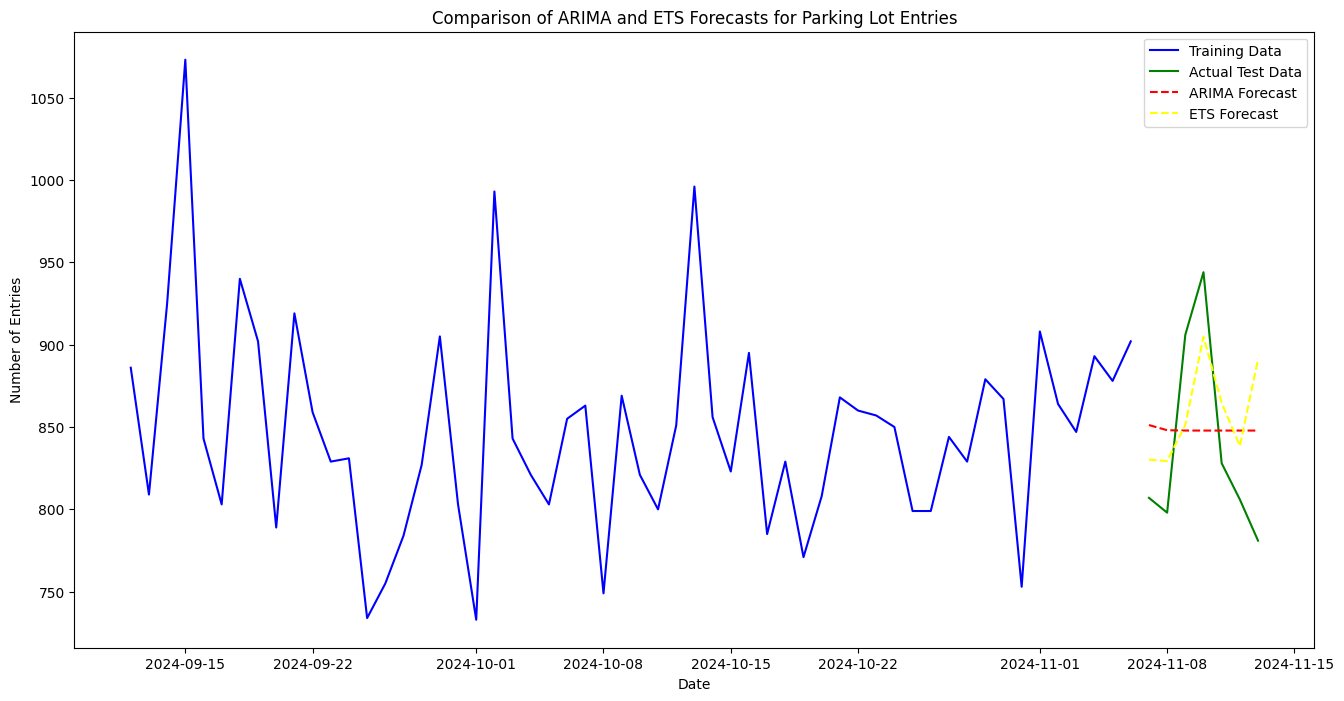

In [12]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(train_data.index, train_data, color='blue', label='Training Data')
ax.plot(test_data.index, test_data, color='green', label='Actual Test Data')
ax.plot(test_data.index, arima_predictions, color='red', linestyle='--', label='ARIMA Forecast')
ax.plot(test_data.index, ets_predictions, color='yellow', linestyle='--', label='ETS Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Entries')
ax.set_title('Comparison of ARIMA and ETS Forecasts for Parking Lot Entries')
ax.legend()
plt.show()